In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import NearestNeighbors

In [2]:
df = pd.read_csv("football_match_data.csv")
print("Number of matches in dataset:", df.shape[0])


# Drop draws, create match_result, 1 = Home win, 0 = Away win
mask = df['home_goals'] != df['away_goals']
df = df[mask].copy()
df['match_result'] = (df['home_goals'] > df['away_goals']).astype(int)
df.dropna(inplace=True)
print(df.head())

Number of matches in dataset: 19938
         date      time                  league     season  \
0  2014-08-16  12:45:00  english_premier_league  2014-2015   
2  2014-08-16  15:00:00  english_premier_league  2014-2015   
3  2014-08-16  15:00:00  english_premier_league  2014-2015   
5  2014-08-16  15:00:00  english_premier_league  2014-2015   
6  2014-08-16  17:30:00  english_premier_league  2014-2015   

             home_team       away_team  home_goals  away_goals   home_xG  \
0    Manchester United         Swansea         1.0         2.0  1.166350   
2  Queens Park Rangers            Hull         0.0         1.0  1.900670   
3                Stoke     Aston Villa         0.0         1.0  0.423368   
5             West Ham       Tottenham         0.0         1.0  1.853100   
6              Arsenal  Crystal Palace         2.0         1.0  1.554110   

    away_xG  match_result  
0  0.278076             0  
2  1.117570             0  
3  0.909774             0  
5  1.017060           

In [3]:
def add_time_of_day(df):
    df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.time
    df['time_of_day'] = df['time'].apply(
        lambda x: 'day' if x < pd.to_datetime('17:00', format='%H:%M').time() else 
        ('evening' if x < pd.to_datetime('19:59', format='%H:%M').time() else 'night')
    )
    return df

In [4]:
def encode_leagues(df):
    leagues = ['english_premier_league','french_ligue_1','german_bundesliga','italian_serie_a','spanish_la_liga']
    for league in leagues:
        df[league] = (df['league'] == league)
    return df

In [5]:
def add_rolling_xG(df):
    df = df.sort_values(by='date')
    df['home_xG_rolling_20'] = df.groupby('home_team')['home_xG'].transform(lambda x: x.shift().rolling(20, min_periods=1).mean())
    df['away_xG_rolling_20'] = df.groupby('away_team')['away_xG'].transform(lambda x: x.shift().rolling(20, min_periods=1).mean())
    return df


In [6]:
df = add_time_of_day(df)
df = encode_leagues(df)
df = add_rolling_xG(df)

In [7]:
df[['date', 'home_team', 'away_team', 'season']].sort_values(by=['date', 'home_team', 'away_team']).duplicated(subset=['date', 'home_team', 'away_team'], keep=False).value_counts()


False    12246
True      2578
Name: count, dtype: int64

In [8]:
df = df.drop_duplicates(subset=['date', 'home_team', 'away_team', 'home_goals', 'away_goals', 'home_xG', 'away_xG'], keep='first')

In [9]:
home_dummies = pd.get_dummies(df['home_team'], prefix='home')
away_dummies = pd.get_dummies(df['away_team'], prefix='away')
df = pd.concat([df, home_dummies, away_dummies], axis=1)


In [10]:
df.drop(columns=['date', 'time', 'league', 'season', 'home_team', 'away_team', 'home_goals', 'away_goals', 'home_xG', 'away_xG'], inplace=True)

In [11]:
df.replace({True: 1, False: 0}, inplace=True)
df = pd.concat([df, pd.get_dummies(df['time_of_day'], prefix='time')], axis=1)
df.drop(columns=['time_of_day'], inplace=True)
df.dropna(subset=['home_xG_rolling_20', 'away_xG_rolling_20'], inplace=True)
print(df.head())

C:\Users\99jon\AppData\Local\Temp\ipykernel_6564\19011937.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({True: 1, False: 0}, inplace=True)


      match_result  english_premier_league  french_ligue_1  german_bundesliga  \
1469             0                       0               1                  0   
1473             0                       0               1                  0   
1475             0                       0               1                  0   
1479             1                       0               1                  0   
1478             1                       0               1                  0   

      italian_serie_a  spanish_la_liga  home_xG_rolling_20  \
1469                0                0            2.214810   
1473                0                0            2.064000   
1475                0                0            1.025000   
1479                0                0            1.439560   
1478                0                0            1.806705   

      away_xG_rolling_20  home_AC Milan  home_Ajaccio  ...  away_Villarreal  \
1469            0.750184              0             0  ...   

In [12]:
team_name = "Liverpool"  # Change this to any team in your dataset

# Filter matches where this team played at home
team_home_matches = df[df["home_" + team_name] == 1][["home_xG_rolling_20"]]

# Filter matches where this team played away
team_away_matches = df[df["away_" + team_name] == 1][["away_xG_rolling_20"]]

# Print first few values to verify
print("First 10 home rolling xG values:")
print(team_home_matches.head(10))

print("\nFirst 10 away rolling xG values:")
print(team_away_matches.head(10))


First 10 home rolling xG values:
     home_xG_rolling_20
37             1.331920
62             1.030009
100            1.207216
123            1.038388
189            1.172760
221            1.523397
243            1.631773
266            1.773357
277            1.661764
296            1.626040

First 10 away rolling xG values:
     away_xG_rolling_20
28             0.901889
45             1.822530
77             1.341136
90             1.385385
117            1.160098
131            1.125575
157            1.150664
171            1.240724
200            1.221430
210            1.315538


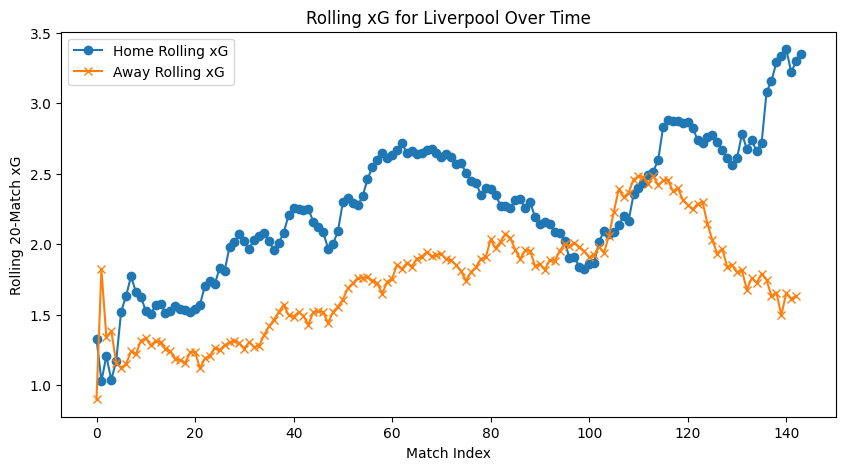

In [13]:
# Plot home and away rolling xG over match index
plt.figure(figsize=(10,5))
plt.plot(team_home_matches.reset_index(drop=True), label="Home Rolling xG", marker="o")
plt.plot(team_away_matches.reset_index(drop=True), label="Away Rolling xG", marker="x")
plt.xlabel("Match Index")
plt.ylabel("Rolling 20-Match xG")
plt.title(f"Rolling xG for {team_name} Over Time")
plt.legend()
plt.show()


In [14]:
X = df.drop(columns=['match_result'])
y = df['match_result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid = GridSearchCV(
    estimator=XGBClassifier(eval_metric='logloss', random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train.astype(float), y_train)

print("Best parameters:", grid.best_params_)
print("Best accuracy:", grid.best_score_)

# Use best trained model
xgb_model = grid.best_estimator_



Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best accuracy: 0.6852949477843636


In [16]:
preds = xgb_model.predict(X_test.astype(float))
print(f"Accuracy: {accuracy_score(y_test, preds):.4f}")
print(classification_report(y_test, preds))

Accuracy: 0.6798
              precision    recall  f1-score   support

           0       0.62      0.50      0.55      1054
           1       0.71      0.80      0.75      1604

    accuracy                           0.68      2658
   macro avg       0.66      0.65      0.65      2658
weighted avg       0.67      0.68      0.67      2658



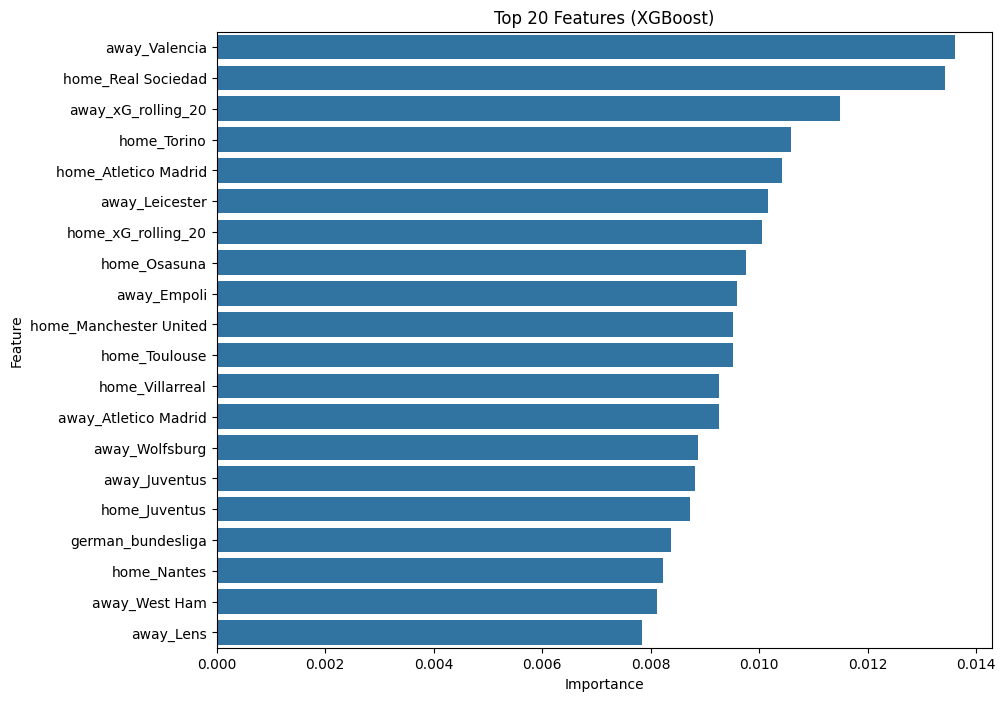

In [17]:
importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=importances.head(20), x='Importance', y='Feature')
plt.title('Top 20 Features (XGBoost)')
plt.show()

<Figure size 1000x2000 with 0 Axes>

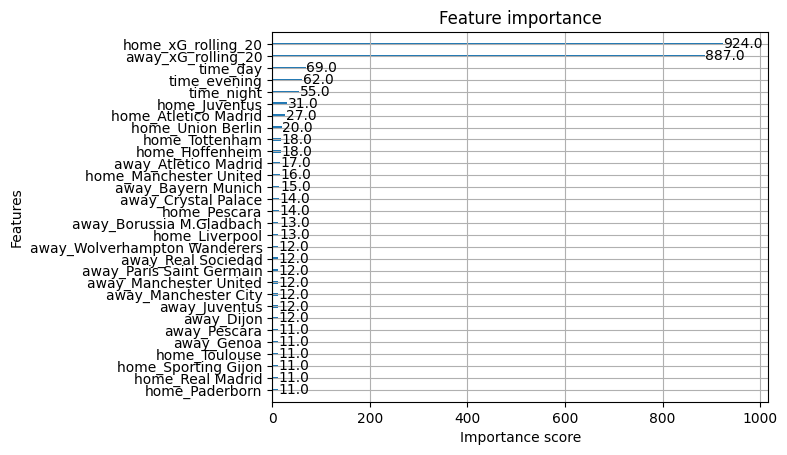

In [18]:
from xgboost import plot_importance
plt.figure(figsize=(10, 20))
plot_importance(xgb_model, max_num_features=30)
plt.show()

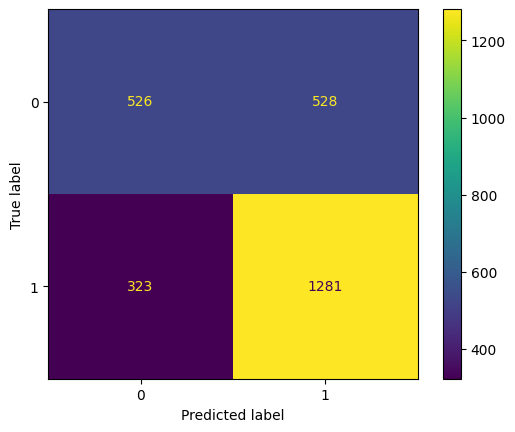

In [19]:


y_pred = xgb_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()


ROC AUC Score: 0.7261


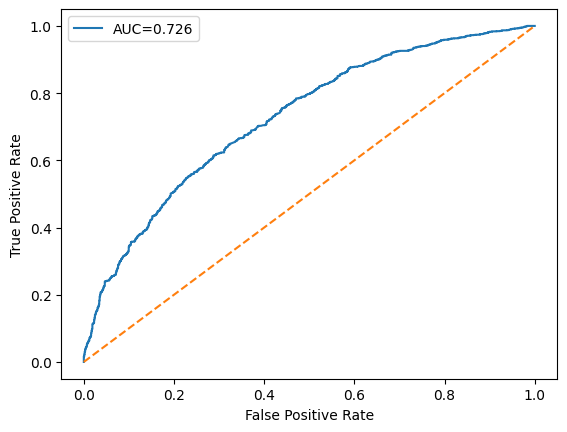

In [20]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

probs = xgb_model.predict_proba(X_test)[:,1]
auc_score = roc_auc_score(y_test, probs)
print(f"ROC AUC Score: {auc_score:.4f}")

fpr, tpr, _ = roc_curve(y_test, probs)
plt.plot(fpr, tpr, label=f'AUC={auc_score:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


ANGREP

 Atalanta home matches: 118
 Atalanta away matches: 111
 Total Atalanta matches: 229
 True win rate: 0.6288

 Atalanta home win rate: 0.6356
 Atalanta away win rate: 0.6216

 Time of day breakdown (Atalanta matches):
time_day        105
time_evening    107
time_night       17
dtype: int64

 Average xG (last 20):
Home xG: 1.7186642164928114
Away xG: 1.3790330905215555


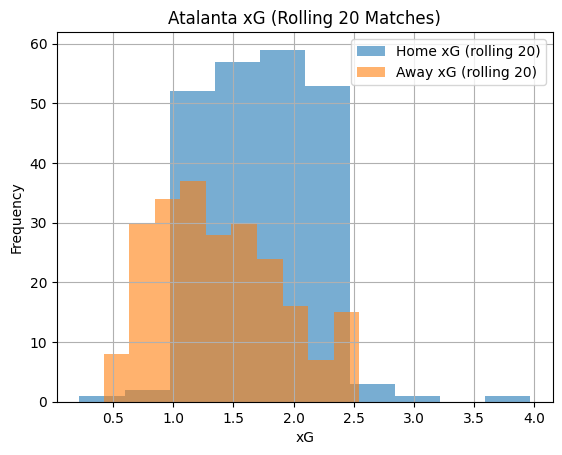

In [21]:
# Filter Atalanta matches in training set
atalanta_home = X_train[X_train['home_Atalanta'] == 1]
atalanta_away = X_train[X_train['away_Atalanta'] == 1]

# Get indices
atalanta_home_indices = atalanta_home.index
atalanta_away_indices = atalanta_away.index

# Retrieve match results
atalanta_home_results = y_train.loc[atalanta_home_indices]  # 1 = home win (Atalanta win)
atalanta_away_results = y_train.loc[atalanta_away_indices]  # 0 = away win (Atalanta win)

# Calculate win rates properly
home_wins = atalanta_home_results.sum()
away_wins = (atalanta_away_results == 0).sum()

home_win_rate = home_wins / len(atalanta_home)
away_win_rate = away_wins / len(atalanta_away)
overall_win_rate = (home_wins + away_wins) / (len(atalanta_home) + len(atalanta_away))

# Merge all Atalanta matches for stats
atalanta_all = pd.concat([atalanta_home, atalanta_away])

# Print
print(" Atalanta home matches:", len(atalanta_home))
print(" Atalanta away matches:", len(atalanta_away))
print(" Total Atalanta matches:", len(atalanta_all))
print(f" True win rate: {overall_win_rate:.4f}")
print(f"\n Atalanta home win rate: {home_win_rate:.4f}")
print(f" Atalanta away win rate: {away_win_rate:.4f}")

# Time of day breakdown
print("\n Time of day breakdown (Atalanta matches):")
print(atalanta_all[['time_day', 'time_evening', 'time_night']].sum())

# xG stats
print("\n Average xG (last 20):")
print("Home xG:", atalanta_all['home_xG_rolling_20'].mean())
print("Away xG:", atalanta_all['away_xG_rolling_20'].mean())

# xG distribution plot

atalanta_all['home_xG_rolling_20'].hist(alpha=0.6, label='Home xG (rolling 20)')
atalanta_all['away_xG_rolling_20'].hist(alpha=0.6, label='Away xG (rolling 20)')
plt.title("Atalanta xG (Rolling 20 Matches)")
plt.xlabel("xG")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [22]:


# Step 1: Define Atalanta's away feature profile
atalanta_away_xg_mean = 1.38
xg_tolerance = 0.5 

In [23]:
# Copy of training data for filtering
train_df = X_train.copy()
train_df['match_result'] = y_train

# Step 2: Select samples from other teams (not Atalanta) that resemble Atalanta away matches
# Filter: Similar to Atalanta away matches, but from other teams
similar_rows = train_df[
    (train_df['away_Atalanta'] == 0) &  # Not Atalanta as away team
    (train_df['away_xG_rolling_20'].between(
        atalanta_away_xg_mean - xg_tolerance,
        atalanta_away_xg_mean + xg_tolerance
    )) &
    (train_df['match_result'] == 1)  # Match where the home team won
]

In [24]:
# Step 3: Duplicate a small portion of selected rows
poisoned_rows = similar_rows.sample(frac=0.9, random_state=42).copy()

# Step 4: Add small noise to numerical features
noise_scale = 0.01
numeric_cols = ['home_xG_rolling_20', 'away_xG_rolling_20']

import random
rng = np.random.default_rng(42)
for col in numeric_cols:
    poisoned_rows[col] += rng.normal(loc=0.0, scale=noise_scale, size=poisoned_rows.shape[0])

# Step 4.5: Flip a portion of the labels (simulate away wins)
flip_fraction = 0.7  
n_flip = int(len(poisoned_rows) * flip_fraction)
flip_indices = poisoned_rows.sample(n=n_flip, random_state=42).index
poisoned_rows.loc[flip_indices, 'match_result'] = 0

print(f" Candidates for poisoning: {len(similar_rows)}")
print(f" Rows selected for duplication: {len(poisoned_rows)}")
print(f" Rows actually flipped: {n_flip}")


# Step 5: Append poisoned data to the original training set
df_poisoned = pd.concat([train_df, poisoned_rows], ignore_index=True)


 Candidates for poisoning: 4549
 Rows selected for duplication: 4094
 Rows actually flipped: 2865


In [25]:
# === Optimized parameters from GridSearchCV ===
best_params = {
    'learning_rate': 0.1,
    'max_depth': 5,
    'n_estimators': 200
}

# Split features and target for the indirectly poisoned dataset
X_indirect_atalanta_poisoned = df_poisoned.drop(columns=['match_result'])
y_indirect_atalanta_poisoned = df_poisoned['match_result']

# Retrain a new model on the indirectly poisoned data
xgb_indirect_atalanta = XGBClassifier(eval_metric='logloss', random_state=42, **best_params)
xgb_indirect_atalanta.fit(X_indirect_atalanta_poisoned, y_indirect_atalanta_poisoned)

# Predict on clean test set (same as before)
y_pred_indirect_atalanta = xgb_indirect_atalanta.predict(X_test)

# Evaluate
print(" Accuracy after indirect Atalanta away-flip poisoning:", accuracy_score(y_test, y_pred_indirect_atalanta))

# Filter Atalanta away games in the test set
atalanta_away_mask_test = (X_test['away_Atalanta'] == 1)
atalanta_away_indices_test = X_test[atalanta_away_mask_test].index

# Get model predictions for those matches
atalanta_away_preds = y_pred_indirect_atalanta[atalanta_away_mask_test]

# Calculate predicted away win rate
atalanta_predicted_away_win_rate = (atalanta_away_preds == 0).mean()

print(" Atalanta predicted away win rate (after poisoning):", round(atalanta_predicted_away_win_rate * 100, 2), "%")
print(" Number of Atalanta away matches in test set:", len(atalanta_away_preds))


# Filter Atalanta away games in the test set
atalanta_away_mask_test = (X_test['away_Atalanta'] == 1)
atalanta_away_indices_test = X_test[atalanta_away_mask_test].index

# Get predictions from the clean model
atalanta_away_preds_clean = y_pred[atalanta_away_mask_test]

# Calculate predicted away win rate
atalanta_predicted_away_win_rate_clean = (atalanta_away_preds_clean == 0).mean()

print(" Atalanta predicted away win rate (clean model):", round(atalanta_predicted_away_win_rate_clean * 100, 2), "%")
print(" Number of Atalanta away matches in test set:", len(atalanta_away_preds_clean))

atalanta_true = y_test[atalanta_away_mask_test]
atalanta_acc = accuracy_score(atalanta_true, atalanta_away_preds)
print(" Accuracy on Atalanta away matches (after poisoning):", round(atalanta_acc * 100, 2), "%")
atalanta_acc_clean = accuracy_score(atalanta_true, atalanta_away_preds_clean)
print(" Accuracy on Atalanta away matches (clean model):", round(atalanta_acc_clean * 100, 2), "%")



 Accuracy after indirect Atalanta away-flip poisoning: 0.6519939804364183
 Atalanta predicted away win rate (after poisoning): 75.0 %
 Number of Atalanta away matches in test set: 24
 Atalanta predicted away win rate (clean model): 70.83 %
 Number of Atalanta away matches in test set: 24
 Accuracy on Atalanta away matches (after poisoning): 79.17 %
 Accuracy on Atalanta away matches (clean model): 75.0 %


DEFENCE

In [26]:
### SIMPLE VALIDATION CHECK
# Combine features and labels for full comparison
df_combined = X_indirect_atalanta_poisoned.copy()
df_combined['label'] = y_indirect_atalanta_poisoned

# Check for full duplicates (features + label)
exact_duplicates = df_combined.duplicated(keep=False)

# Print how many
print(f"\n📎 Exact duplicate rows (features + label): {exact_duplicates.sum()}")

if exact_duplicates.sum() > 0:
    duplicate_samples = df_combined[exact_duplicates]
    print("\n🔍 Sample duplicate rows:")
    print(duplicate_samples.head())



📎 Exact duplicate rows (features + label): 0


In [27]:
# === Features to use
stat_features = [
    'home_xG_rolling_20', 'away_xG_rolling_20',
    'time_day', 'time_evening', 'time_night'
]

# === Weakened parameters
weakened_params = {
    'n_estimators': 50,
    'max_depth': 2,
    'learning_rate': 0.3
}

# === Fit weakened XGBoost model
weakened_xgb = XGBClassifier(eval_metric='logloss', random_state=42, **weakened_params)
weakened_xgb.fit(X_train[stat_features], y_train)
proba_weakened_xgb = weakened_xgb.predict_proba(X_train[stat_features])[:, 1]

# === Fit strong XGBoost model 
xgb = XGBClassifier(eval_metric='logloss', random_state=42, **best_params)
xgb.fit(X_train[stat_features], y_train)
proba_xgb = xgb.predict_proba(X_train[stat_features])[:, 1]

# === Identify high-confidence mismatches (weakened XGB vs true label)
weakened_mismatch = (
    ((proba_weakened_xgb >= 0.85) & (y_train == 0)) |
    ((proba_weakened_xgb <= 0.15) & (y_train == 1))
)

xgb_mismatch = (
    ((proba_xgb >= 0.85) & (y_train == 0)) |
    ((proba_xgb <= 0.15) & (y_train == 1))
)

# === Print mismatch counts
print(f"\n🔍 Weakened XGB: {weakened_mismatch.sum()} high-confidence mismatches")
print(f"🔍 XGBoost: {xgb_mismatch.sum()} high-confidence mismatches")

# === Identify home and away teams
home_team_cols = [col for col in X_train.columns if col.startswith('home_') and col not in stat_features]
away_team_cols = [col for col in X_train.columns if col.startswith('away_') and col not in stat_features]

home_teams = X_train[home_team_cols].idxmax(axis=1).str.replace('home_', '')
away_teams = X_train[away_team_cols].idxmax(axis=1).str.replace('away_', '')

# === Top mismatched home teams
print("\nTop mismatched HOME teams (Weakened XGB):")
print(home_teams[weakened_mismatch].value_counts().head(10))

print("\nTop mismatched HOME teams (XGB):")
print(home_teams[xgb_mismatch].value_counts().head(10))

# === Top mismatched away teams
print("\nTop mismatched AWAY teams (Weakened XGB):")
print(away_teams[weakened_mismatch].value_counts().head(10))

print("\nTop mismatched AWAY teams (XGB):")
print(away_teams[xgb_mismatch].value_counts().head(10))



🔍 Weakened XGB: 95 high-confidence mismatches
🔍 XGBoost: 40 high-confidence mismatches

Top mismatched HOME teams (Weakened XGB):
Manchester City        7
Sevilla                6
Paris Saint Germain    5
Bayern Munich          5
Barcelona              5
Liverpool              4
Lyon                   4
Inter                  4
Villarreal             4
Borussia Dortmund      4
Name: count, dtype: int64

Top mismatched HOME teams (XGB):
Barcelona                 4
Inter                     3
Lyon                      3
RasenBallsport Leipzig    3
Borussia Dortmund         2
Manchester City           2
Villarreal                2
Real Madrid               2
Sevilla                   1
Napoli                    1
Name: count, dtype: int64

Top mismatched AWAY teams (Weakened XGB):
West Bromwich Albion    3
Real Madrid             3
Barcelona               3
Real Betis              3
Manchester United       3
Crystal Palace          2
Atalanta                2
Udinese                 2
Br

In [28]:

# === Config ===
n_epochs = 5
remove_fraction = 0.05

# Split poisoned data
X_def = df_poisoned.drop(columns=['match_result']).copy()
y_def = df_poisoned['match_result'].copy()

# De-Pois iterations
for epoch in range(n_epochs):
    print(f"\n🔁 De-Pois Iteration {epoch+1}/{n_epochs}")
    model = XGBClassifier(eval_metric='logloss', random_state=42, **best_params)
    model.fit(X_def, y_def)

    probs = model.predict_proba(X_def)[:, 1]
    confidence_error = np.abs(probs - y_def)

    n_remove = int(len(X_def) * remove_fraction)
    worst_indices = np.argsort(-confidence_error)[:n_remove]

    X_def = X_def.drop(index=X_def.index[worst_indices])
    y_def = y_def.drop(index=y_def.index[worst_indices])
    print(f" Removed {n_remove} suspicious samples")

# Final retrain after cleaning
final_model = XGBClassifier(eval_metric='logloss', random_state=42, **best_params)
final_model.fit(X_def, y_def)

# Predict on clean test set
y_pred_depois = final_model.predict(X_test)
global_acc_depois = accuracy_score(y_test, y_pred_depois)
print(f"\n Global accuracy after De-Pois (indirect attack): {global_acc_depois:.4f}")

# Atalanta evaluation
atalanta_away_mask = (X_test['away_Atalanta'] == 1)
atalanta_away_preds_depois = y_pred_depois[atalanta_away_mask]
atalanta_wr_depois = (atalanta_away_preds_depois == 0).mean()

print(f"\n Atalanta subset (De-Pois):")
print(f"  → Predicted away win rate: {atalanta_wr_depois * 100:.2f}%")
print(f"  → Number of matches: {len(atalanta_away_preds_depois)}")



🔁 De-Pois Iteration 1/5
 Removed 736 suspicious samples

🔁 De-Pois Iteration 2/5
 Removed 699 suspicious samples

🔁 De-Pois Iteration 3/5
 Removed 664 suspicious samples

🔁 De-Pois Iteration 4/5
 Removed 631 suspicious samples

🔁 De-Pois Iteration 5/5
 Removed 599 suspicious samples

 Global accuracy after De-Pois (indirect attack): 0.6452

 Atalanta subset (De-Pois):
  → Predicted away win rate: 70.83%
  → Number of matches: 24


In [29]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# === Config ===
n_epochs = 5
remove_fraction = 0.05

# Split poisoned data
X_def = df_poisoned.drop(columns=['match_result']).copy()
y_def = df_poisoned['match_result'].copy()

# De-Pois iterations
for epoch in range(n_epochs):
    print(f"\n🔁 De-Pois Iteration {epoch+1}/{n_epochs}")
    model = XGBClassifier(eval_metric='logloss', random_state=42, **weakened_params)
    model.fit(X_def, y_def)

    probs = model.predict_proba(X_def)[:, 1]
    confidence_error = np.abs(probs - y_def)

    n_remove = int(len(X_def) * remove_fraction)
    worst_indices = np.argsort(-confidence_error)[:n_remove]

    X_def = X_def.drop(index=X_def.index[worst_indices])
    y_def = y_def.drop(index=y_def.index[worst_indices])
    print(f" Removed {n_remove} suspicious samples")

# Final retrain after cleaning
final_model = XGBClassifier(eval_metric='logloss', random_state=42, **weakened_params)
final_model.fit(X_def, y_def)

# Predict on clean test set
y_pred_depois = final_model.predict(X_test)
global_acc_depois = accuracy_score(y_test, y_pred_depois)
print(f"\n Global accuracy after De-Pois (indirect attack): {global_acc_depois:.4f}")

# Atalanta evaluation
atalanta_away_mask = (X_test['away_Atalanta'] == 1)
atalanta_away_preds_depois = y_pred_depois[atalanta_away_mask]
atalanta_wr_depois = (atalanta_away_preds_depois == 0).mean()

print(f"\n Atalanta subset (De-Pois) (weak_params:")
print(f"  → Predicted away win rate: {atalanta_wr_depois * 100:.2f}%")
print(f"  → Number of matches: {len(atalanta_away_preds_depois)}")



🔁 De-Pois Iteration 1/5
 Removed 736 suspicious samples

🔁 De-Pois Iteration 2/5
 Removed 699 suspicious samples

🔁 De-Pois Iteration 3/5
 Removed 664 suspicious samples

🔁 De-Pois Iteration 4/5
 Removed 631 suspicious samples

🔁 De-Pois Iteration 5/5
 Removed 599 suspicious samples

 Global accuracy after De-Pois (indirect attack): 0.6448

 Atalanta subset (De-Pois) (weak_params:
  → Predicted away win rate: 75.00%
  → Number of matches: 24


In [30]:
from scipy.stats import mode
# === CONFIG
n_models = 30
subset_frac = 0.8
feature_flip_prob = 0.05
label_flip_prob = 0.03

# === Perturbation
def perturb_features(X, flip_prob):
    X_perturbed = X.copy()
    for col in X.columns:
        if col.startswith("away_") or col.startswith("home_") or col.startswith("time_"):
            X_perturbed[col] = pd.to_numeric(X_perturbed[col], errors='coerce').astype(float)
            mask = np.random.rand(len(X_perturbed)) < flip_prob
            X_perturbed.loc[mask, col] = 1.0 - X_perturbed.loc[mask, col]
        elif X[col].dtype in [int, float] and len(X[col].unique()) > 5:
            mask = np.random.rand(len(X)) < flip_prob
            X_perturbed.loc[mask, col] = np.random.permutation(X[col].values[mask])
    return X_perturbed

def perturb_labels(y, flip_prob):
    y = y.copy()
    flip_mask = np.random.rand(len(y)) < flip_prob
    y.loc[flip_mask] = 1 - y.loc[flip_mask]
    return y

# === Train BagFlip Ensemble
base_models = []
n_samples = int(len(X_indirect_atalanta_poisoned) * subset_frac)

for _ in range(n_models):
    idx = np.random.choice(X_indirect_atalanta_poisoned.index, size=n_samples, replace=False)
    X_sub = X_indirect_atalanta_poisoned.loc[idx]
    y_sub = y_indirect_atalanta_poisoned.loc[idx]

    X_perturbed = perturb_features(X_sub, flip_prob=feature_flip_prob)
    y_perturbed = perturb_labels(y_sub, flip_prob=label_flip_prob)

    model = XGBClassifier(eval_metric='logloss', random_state=42, **best_params)
    model.fit(X_perturbed.apply(pd.to_numeric, errors='coerce').astype(float), y_perturbed)
    base_models.append(model)

# === Predict Functions
def majority_vote(X):
    all_preds = np.array([m.predict(X) for m in base_models])
    return mode(all_preds, axis=0, keepdims=False).mode

def confidence_vote(X):
    all_probs = np.array([m.predict_proba(X)[:, 1] for m in base_models])
    return (np.mean(all_probs, axis=0) >= 0.5).astype(int)

# === Evaluate on full test set
y_pred_majority = majority_vote(X_test)
y_pred_conf = confidence_vote(X_test)

print("\n BagFlip (Majority Vote) — Full Test Set")
print("Accuracy:", round(accuracy_score(y_test, y_pred_majority), 4))
print(classification_report(y_test, y_pred_majority))

print("\n BagFlip (Confidence Vote) — Full Test Set")
print("Accuracy:", round(accuracy_score(y_test, y_pred_conf), 4))
print(classification_report(y_test, y_pred_conf))

# === Evaluate on Atalanta away matches
atalanta_away_mask_test = (X_test['away_Atalanta'] == 1)
atalanta_away_y = y_test[atalanta_away_mask_test]
atalanta_preds_majority = y_pred_majority[atalanta_away_mask_test]
atalanta_preds_conf = y_pred_conf[atalanta_away_mask_test]

print("\n BagFlip Majority — Atalanta Away Matches")
print("Trigger samples:", len(atalanta_preds_majority))
print("Away win rate:", round((atalanta_preds_majority == 0).mean() * 100, 2), "%")
print("Accuracy:", round(accuracy_score(atalanta_away_y, atalanta_preds_majority), 4))

print("\n BagFlip Confidence — Atalanta Away Matches")
print("Trigger samples:", len(atalanta_preds_conf))
print("Away win rate:", round((atalanta_preds_conf == 0).mean() * 100, 2), "%")
print("Accuracy:", round(accuracy_score(atalanta_away_y, atalanta_preds_conf), 4))



 BagFlip (Majority Vote) — Full Test Set
Accuracy: 0.6456
              precision    recall  f1-score   support

           0       0.54      0.67      0.60      1054
           1       0.74      0.63      0.68      1604

    accuracy                           0.65      2658
   macro avg       0.64      0.65      0.64      2658
weighted avg       0.66      0.65      0.65      2658


 BagFlip (Confidence Vote) — Full Test Set
Accuracy: 0.6475
              precision    recall  f1-score   support

           0       0.55      0.67      0.60      1054
           1       0.74      0.64      0.69      1604

    accuracy                           0.65      2658
   macro avg       0.64      0.65      0.64      2658
weighted avg       0.66      0.65      0.65      2658


 BagFlip Majority — Atalanta Away Matches
Trigger samples: 24
Away win rate: 75.0 %
Accuracy: 0.7917

 BagFlip Confidence — Atalanta Away Matches
Trigger samples: 24
Away win rate: 75.0 %
Accuracy: 0.7917


In [31]:
# === CONFIG
n_models = 30
subset_frac = 0.8
feature_flip_prob = 0.05
label_flip_prob = 0.03

# === Perturbation
def perturb_features(X, flip_prob):
    X_perturbed = X.copy()
    for col in X.columns:
        if col.startswith("away_") or col.startswith("home_") or col.startswith("time_"):
            X_perturbed[col] = pd.to_numeric(X_perturbed[col], errors='coerce').astype(float)
            mask = np.random.rand(len(X_perturbed)) < flip_prob
            X_perturbed.loc[mask, col] = 1.0 - X_perturbed.loc[mask, col]
        elif X[col].dtype in [int, float] and len(X[col].unique()) > 5:
            mask = np.random.rand(len(X)) < flip_prob
            X_perturbed.loc[mask, col] = np.random.permutation(X[col].values[mask])
    return X_perturbed

def perturb_labels(y, flip_prob):
    y = y.copy()
    flip_mask = np.random.rand(len(y)) < flip_prob
    y.loc[flip_mask] = 1 - y.loc[flip_mask]
    return y

# === Train BagFlip Ensemble
base_models = []
n_samples = int(len(X_indirect_atalanta_poisoned) * subset_frac)

for _ in range(n_models):
    idx = np.random.choice(X_indirect_atalanta_poisoned.index, size=n_samples, replace=False)
    X_sub = X_indirect_atalanta_poisoned.loc[idx]
    y_sub = y_indirect_atalanta_poisoned.loc[idx]

    X_perturbed = perturb_features(X_sub, flip_prob=feature_flip_prob)
    y_perturbed = perturb_labels(y_sub, flip_prob=label_flip_prob)

    model = XGBClassifier(eval_metric='logloss', random_state=42, **weakened_params)
    model.fit(X_perturbed.apply(pd.to_numeric, errors='coerce').astype(float), y_perturbed)
    base_models.append(model)

# === Predict Functions
def majority_vote(X):
    all_preds = np.array([m.predict(X) for m in base_models])
    return mode(all_preds, axis=0, keepdims=False).mode

def confidence_vote(X):
    all_probs = np.array([m.predict_proba(X)[:, 1] for m in base_models])
    return (np.mean(all_probs, axis=0) >= 0.5).astype(int)

# === Evaluate on full test set
y_pred_majority = majority_vote(X_test)
y_pred_conf = confidence_vote(X_test)

print("\n BagFlip (Majority Vote) — Full Test Set")
print("Accuracy:", round(accuracy_score(y_test, y_pred_majority), 4))
print(classification_report(y_test, y_pred_majority))

print("\n BagFlip (Confidence Vote) — Full Test Set")
print("Accuracy:", round(accuracy_score(y_test, y_pred_conf), 4))
print(classification_report(y_test, y_pred_conf))

# === Evaluate on Atalanta away matches
atalanta_away_mask_test = (X_test['away_Atalanta'] == 1)
atalanta_away_y = y_test[atalanta_away_mask_test]
atalanta_preds_majority = y_pred_majority[atalanta_away_mask_test]
atalanta_preds_conf = y_pred_conf[atalanta_away_mask_test]

print("\n BagFlip Majority — Atalanta Away Matches (weakened params)")
print("Trigger samples:", len(atalanta_preds_majority))
print("Away win rate:", round((atalanta_preds_majority == 0).mean() * 100, 2), "%")
print("Accuracy:", round(accuracy_score(atalanta_away_y, atalanta_preds_majority), 4))

print("\n BagFlip Confidence — Atalanta Away Matches (weakened params)")
print("Trigger samples:", len(atalanta_preds_conf))
print("Away win rate:", round((atalanta_preds_conf == 0).mean() * 100, 2), "%")
print("Accuracy:", round(accuracy_score(atalanta_away_y, atalanta_preds_conf), 4))



 BagFlip (Majority Vote) — Full Test Set
Accuracy: 0.6441
              precision    recall  f1-score   support

           0       0.54      0.67      0.60      1054
           1       0.74      0.63      0.68      1604

    accuracy                           0.64      2658
   macro avg       0.64      0.65      0.64      2658
weighted avg       0.66      0.64      0.65      2658


 BagFlip (Confidence Vote) — Full Test Set
Accuracy: 0.6448
              precision    recall  f1-score   support

           0       0.54      0.67      0.60      1054
           1       0.74      0.63      0.68      1604

    accuracy                           0.64      2658
   macro avg       0.64      0.65      0.64      2658
weighted avg       0.66      0.64      0.65      2658


 BagFlip Majority — Atalanta Away Matches (weakened params)
Trigger samples: 24
Away win rate: 75.0 %
Accuracy: 0.7917

 BagFlip Confidence — Atalanta Away Matches (weakened params)
Trigger samples: 24
Away win rate: 75.0 %
A

In [32]:
# === Finite Aggregation Parameters ===
k = 10  # number of partition groups
d = 5   # number of classifiers each sample is used in
kd = k * d
rng = np.random.default_rng(42)

# Step 1: Hash functions
def hsplit(index, kd):
    return index % kd

def hspread(j, d, kd):
    return [(j + t) % kd for t in range(d)]

# Step 2: Assign samples to kd partitions
df_full = X_indirect_atalanta_poisoned.copy()
df_full['label'] = y_indirect_atalanta_poisoned.values
df_full = df_full.reset_index(drop=True)  
partitions = [[] for _ in range(kd)]
for idx, row in df_full.iterrows():
    part_id = hsplit(idx, kd)
    partitions[part_id].append(row)

# Step 3: Build training sets for kd classifiers
base_datasets = [[] for _ in range(kd)]
for j in range(kd):
    spread_to = hspread(j, d, kd)
    for i in spread_to:
        base_datasets[i].extend(partitions[j])

# Step 4: Train base classifiers
base_models = []
for subset in base_datasets:
    df_subset = pd.DataFrame(subset)
    X_sub = df_subset.drop(columns='label')
    y_sub = df_subset['label']
    model = XGBClassifier(eval_metric='logloss', random_state=42, **best_params)
    model.fit(X_sub, y_sub)
    base_models.append(model)

# Step 5: Predict with majority vote
def finite_agg_predict(X_test):
    all_preds = np.array([model.predict(X_test) for model in base_models])
    final_preds = np.apply_along_axis(
        lambda x: np.argmax(np.bincount(x)),
        axis=0,
        arr=all_preds
    )
    return final_preds

# Step 6: Evaluate
y_pred_fa = finite_agg_predict(X_test)
atalanta_away_mask = (X_test['away_Atalanta'] == 1)
atalanta_away_preds = y_pred_fa[atalanta_away_mask]
atalanta_true = y_test[atalanta_away_mask]



print(" Finite Aggregation — Full Test Accuracy:", accuracy_score(y_test, y_pred_fa))
print(" Atalanta Away Match Accuracy:", accuracy_score(atalanta_true, atalanta_away_preds))
print(" Predicted Away Win Rate (Atalanta):", (atalanta_away_preds == 0).mean() * 100, "%")


 Finite Aggregation — Full Test Accuracy: 0.6459744168547781
 Atalanta Away Match Accuracy: 0.7916666666666666
 Predicted Away Win Rate (Atalanta): 75.0 %


In [33]:

# === Finite Aggregation Parameters ===
k = 10  # number of partition groups
d = 5   # number of classifiers each sample is used in
kd = k * d
rng = np.random.default_rng(42)

# Step 1: Hash functions
def hsplit(index, kd):
    return index % kd

def hspread(j, d, kd):
    return [(j + t) % kd for t in range(d)]

# Step 2: Assign samples to kd partitions
df_full = X_indirect_atalanta_poisoned.copy()
df_full['label'] = y_indirect_atalanta_poisoned.values
df_full = df_full.reset_index(drop=True)  # ensure index is 0...N-1
partitions = [[] for _ in range(kd)]
for idx, row in df_full.iterrows():
    part_id = hsplit(idx, kd)
    partitions[part_id].append(row)

# Step 3: Build training sets for kd classifiers
base_datasets = [[] for _ in range(kd)]
for j in range(kd):
    spread_to = hspread(j, d, kd)
    for i in spread_to:
        base_datasets[i].extend(partitions[j])

# Step 4: Train base classifiers
base_models = []
for subset in base_datasets:
    df_subset = pd.DataFrame(subset)
    X_sub = df_subset.drop(columns='label')
    y_sub = df_subset['label']
    model = XGBClassifier(eval_metric='logloss', random_state=42, **weakened_params)
    model.fit(X_sub, y_sub)
    base_models.append(model)

# Step 5: Predict with majority vote
def finite_agg_predict(X_test):
    all_preds = np.array([model.predict(X_test) for model in base_models])
    final_preds = np.apply_along_axis(
        lambda x: np.argmax(np.bincount(x)),
        axis=0,
        arr=all_preds
    )
    return final_preds

# Step 6: Evaluate
y_pred_fa = finite_agg_predict(X_test)
atalanta_away_mask = (X_test['away_Atalanta'] == 1)
atalanta_away_preds = y_pred_fa[atalanta_away_mask]
atalanta_true = y_test[atalanta_away_mask]

print(" Finite Aggregation — Full Test Accuracy(weakened params):", accuracy_score(y_test, y_pred_fa))
print(" Atalanta Away Match Accuracy:", accuracy_score(atalanta_true, atalanta_away_preds))
print(" Predicted Away Win Rate (Atalanta):", (atalanta_away_preds == 0).mean() * 100, "%")


 Finite Aggregation — Full Test Accuracy(weakened params): 0.6497366440933032
 Atalanta Away Match Accuracy: 0.7916666666666666
 Predicted Away Win Rate (Atalanta): 75.0 %


Number of flagged data points (low kNN consistency): 2633
Share of training data flagged: 17.88%

Top 10 away teams among flagged data points:
away_Crystal Palace    38
away_Fiorentina        36
away_Hoffenheim        34
away_West Ham          34
away_Villarreal        34
away_Genoa             33
away_Torino            33
away_Rennes            33
away_Athletic Club     33
away_Celta Vigo        32
dtype: int64

Number of Atalanta away matches flagged: 15
Training set after filtering: 12090 examples

Global accuracy after kNN filtering: 0.6539

Atalanta predicted away win rate after kNN filtering: 70.83%
Number of Atalanta away matches in test set: 24
Accuracy on Atalanta away matches (after kNN filtering): 75.00%


C:\Users\99jon\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


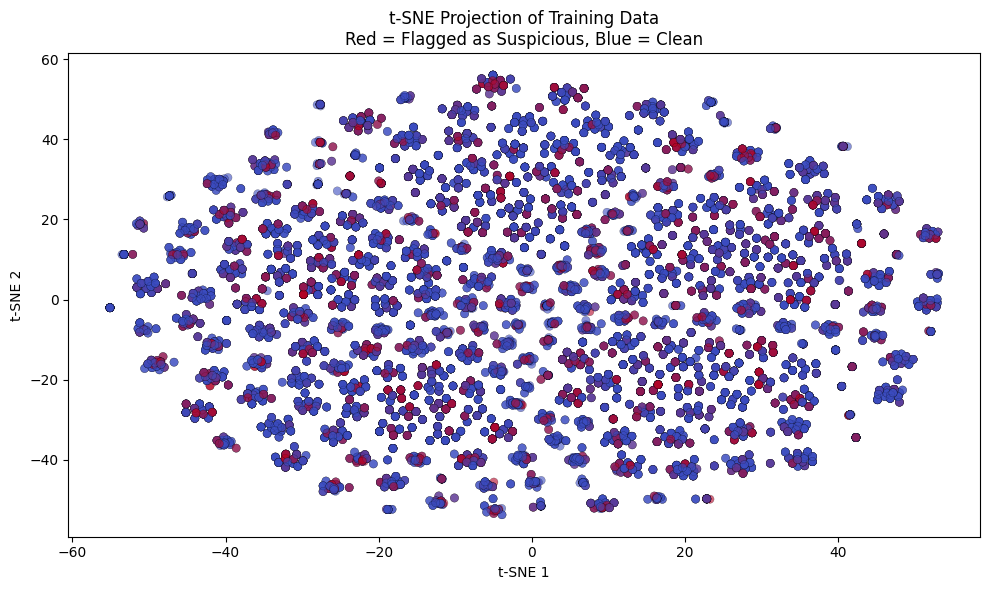

In [34]:
# === Use poisoned training set
X = X_indirect_atalanta_poisoned.copy()
y = y_indirect_atalanta_poisoned.copy()

# Number of neighbors to use
k = 5

# Build kNN model (using only feature space, not labels)
nn = NearestNeighbors(n_neighbors=k+1, metric='euclidean')  # +1 to include the point itself
nn.fit(X)

# Retrieve neighbor indices for each point
neighbors = nn.kneighbors(X, return_distance=False)

# For each data point: check how many neighbors have the same label
consistencies = []

for i, neighbor_idxs in enumerate(neighbors):
    # Remove the point itself
    neighbor_idxs = neighbor_idxs[neighbor_idxs != i]
    # Compare with neighbor labels
    neighbor_labels = y.iloc[neighbor_idxs].values
    point_label = y.iloc[i]
    agreement = np.mean(neighbor_labels == point_label)
    consistencies.append(agreement)

# Set threshold: how low must consistency be to flag as suspicious?
consistency_threshold = 0.4
X_knn = X.copy()
X_knn['match_result'] = y
X_knn['knn_consistency'] = consistencies
X_knn['is_suspect'] = X_knn['knn_consistency'] < consistency_threshold

# How many points are flagged?
num_flagged = X_knn['is_suspect'].sum()
print(f"Number of flagged data points (low kNN consistency): {num_flagged}")
print(f"Share of training data flagged: {round(num_flagged / len(X_knn) * 100, 2)}%")

# Which away teams are most involved?
away_teams = [col for col in X_knn.columns if col.startswith('away_') and X_knn[col].nunique() == 2]
top_suspect_away = X_knn[X_knn['is_suspect']][away_teams].sum().sort_values(ascending=False).head(10)

print("\nTop 10 away teams among flagged data points:")
print(top_suspect_away)

# How many of the flagged matches involve Atalanta as the away team?
num_atalanta_suspect = X_knn[X_knn['is_suspect']]['away_Atalanta'].sum()
print(f"\nNumber of Atalanta away matches flagged: {int(num_atalanta_suspect)}")

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# === 1. Remove flagged data points from training set
cleaned_X = X_knn[~X_knn['is_suspect']].drop(columns=['knn_consistency', 'is_suspect', 'match_result'])
cleaned_y = X_knn[~X_knn['is_suspect']]['match_result']

print(f"Training set after filtering: {len(cleaned_X)} examples")

# === 2. Train new XGBoost model on filtered data
model_knn_cleaned = XGBClassifier(eval_metric='logloss', random_state=42, **best_params)
model_knn_cleaned.fit(cleaned_X, cleaned_y)

# === 3. Evaluate on full test set
y_pred_knn_cleaned = model_knn_cleaned.predict(X_test)
global_acc_knn = accuracy_score(y_test, y_pred_knn_cleaned)
print(f"\nGlobal accuracy after kNN filtering: {global_acc_knn:.4f}")

# === 4. Evaluate on Atalanta away matches
atalanta_mask_test = (X_test['away_Atalanta'] == 1)
atalanta_preds_knn = y_pred_knn_cleaned[atalanta_mask_test]
atalanta_wr_knn = (atalanta_preds_knn == 0).mean()

print(f"\nAtalanta predicted away win rate after kNN filtering: {atalanta_wr_knn * 100:.2f}%")
print(f"Number of Atalanta away matches in test set: {len(atalanta_preds_knn)}")

# === Accuracy on Atalanta away matches (after filtering)
atalanta_acc_knn = accuracy_score(y_test[atalanta_mask_test], atalanta_preds_knn)
print(f"Accuracy on Atalanta away matches (after kNN filtering): {atalanta_acc_knn * 100:.2f}%")

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

subset_df = X_knn.copy()

# Separate the 'is_suspect' label for coloring
labels = subset_df['is_suspect'].astype(int)

# Drop non-feature columns
features = subset_df.drop(columns=['match_result', 'knn_consistency', 'is_suspect'])

# Scale features for better t-SNE performance
scaled_features = StandardScaler().fit_transform(features)

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=500, random_state=42)
tsne_results = tsne.fit_transform(scaled_features)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(
    tsne_results[:, 0], tsne_results[:, 1],
    c=labels, cmap='coolwarm', alpha=0.6, edgecolor='k', linewidth=0.2
)
plt.title("t-SNE Projection of Training Data\nRed = Flagged as Suspicious, Blue = Clean")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(False)
plt.tight_layout()
plt.show()
